In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib widget

from voxel import *
from mol_tools import *
from ML_utils import *

from sklearn.model_selection import train_test_split, KFold

In [2]:
def drop_duplicates(df):
    df = df.drop_duplicates(subset="compound", keep="first")
    print("Number of molecules", df.shape[0])
    return df

In [3]:
def get_all_elements(df):
      return np.unique(np.hstack(np.array(df.species)))

In [4]:
#df = pd.read_pickle("data/icsd_221_cp5_3_species.pkl")
df = pd.read_pickle("data/all_221_cp5_3_species_oxides.pkl")
#df = pd.read_pickle("data/all_3_species_oxides.pkl")

# df = df[~df.enthalpy_formation_atom.isna()]
df = drop_duplicates(df)

Number of molecules 1983


In [5]:
elem_counts = pd.Series(np.hstack(np.array(df.species))).value_counts()
low_freq = elem_counts[elem_counts < 50].index.values
low_freq_mask = df.species.apply(lambda s: len(np.setdiff1d(s, low_freq)) < len(s))
df = df[~low_freq_mask]

In [6]:
elements = get_all_elements(df)
elements

array(['Ag', 'Al', 'As', 'Au', 'B', 'Ba', 'Be', 'Bi', 'Br', 'C', 'Ca',
       'Cd', 'Cl', 'Co', 'Cr', 'Cu', 'F', 'Fe', 'Ga', 'Ge', 'Hf', 'Hg',
       'I', 'In', 'Ir', 'K', 'Li', 'Mg', 'Mn', 'Mo', 'N', 'Na', 'Nb',
       'Ni', 'O', 'Os', 'P', 'Pb', 'Pd', 'Pt', 'Rb', 'Re', 'Rh', 'Ru',
       'S', 'Sb', 'Sc', 'Se', 'Si', 'Sn', 'Sr', 'Ta', 'Tc', 'Te', 'Ti',
       'Tl', 'V', 'W', 'Xe', 'Y', 'Zn', 'Zr'], dtype='<U2')

In [7]:
nchannel = len(elements)
nchannel

62

In [8]:
np.random.seed(0)
train_df, test_df = train_test_split(df, test_size=0.1)

In [9]:
def make_simple_descriptor(mol, elements, one_hot=True):
    descriptor = np.zeros((len(elements),))
    
    for i, (element, n_atoms) in enumerate(zip(mol.species, mol.composition)):
        j = np.where(elements == element)[0][0] # get channel for element
        if one_hot:
            descriptor[j] = 1
        else:
            descriptor[j] = n_atoms
            
    return descriptor

In [10]:
df.loc[0]

auid                                                  aflow:b778fabdb1b01db1
aurl                       aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgAlO/T00...
compound                                                            Ag1Al1O3
composition                                                        [1, 1, 3]
species                                                          [Ag, Al, O]
natoms                                                                     5
spacegroup                                                               221
pearson_symbol                                                           cP5
geometry                   [3.7688035, 3.7688035, 3.7688035, 90.0, 90.0, ...
positions_fractional       [[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.0, 0.5, ...
positions_cartesian        [[0.0, 0.0, 0.0], [1.8844, 1.8844, 1.8844], [0...
enthalpy_atom                                                       -5.04863
enthalpy_formation_atom                                            -0.775736

In [11]:
make_simple_descriptor(df.loc[0], elements)

array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [12]:
seed_everything()
train_df, test_df = train_test_split(df, test_size=0.1)

In [13]:
print(train_df.shape)
print(test_df.shape)

(1713, 13)
(191, 13)


In [14]:
y = df.enthalpy_atom# * df.natoms
y_train = train_df.enthalpy_atom# * train_df.natoms
y_test = test_df.enthalpy_atom# * test_df.natoms

## Zero R

In [15]:
y_pred_train = np.mean(y_train)
np.mean((y_pred_train - y_train)**2)

2.1257655413499155

In [16]:
y_test_pred = np.mean(y_train)
np.mean((y_test_pred - y_test)**2)

2.0241798654478567

In [17]:
seed_everything()
all_ys = []
all_y_hats = []
all_ys_train = []
all_y_hats_train = []

for train_indices, test_indices in KFold(n_splits=5, shuffle=True).split(df):
    
    cv_train_df = df.iloc[train_indices]
    cv_test_df = df.iloc[test_indices]
    
    
    cv_y_train = y.iloc[train_indices] # cv_train_df.enthalpy_atom
    cv_y_test = y.iloc[test_indices] # cv_test_df.enthalpy_atom
    
    cv_y_test_pred = np.mean(cv_y_train)
    
    ys = cv_y_test
    y_hats = np.full_like(cv_y_test, cv_y_test_pred)
    
    y_hats_train = np.full_like(cv_y_train, cv_y_test_pred)
    print("Train:", np.mean((y_hats_train - cv_y_train)**2),
          "Test:", np.mean((y_hats - cv_y_test)**2))
    
    
    all_ys.append(ys)
    all_y_hats.append(y_hats)
    
    all_ys_train.append(cv_y_train)
    all_y_hats_train.append(y_hats_train)
    
print("Avg Train: ", np.mean((np.hstack(all_ys_train) - np.hstack(all_y_hats_train))**2), end=" ")
print("Avg Test: ", np.mean((np.hstack(all_ys) - np.hstack(all_y_hats))**2))

Train: 2.1317049487039093 Test: 2.0605098256665433
Train: 2.0997361722520616 Test: 2.1785569719250355
Train: 2.0939593542313943 Test: 2.2031295460381557
Train: 2.088215533238063 Test: 2.2329070997499936
Train: 2.159537481134354 Test: 1.9411851348668794
Avg Train:  2.1146365942858036 Avg Test:  2.1233533420047745


## Ridge

In [18]:
one_hot=True

In [19]:
X_train = np.vstack(train_df.apply(lambda mol: make_simple_descriptor(mol, elements, one_hot=one_hot), axis=1))
X_test = np.vstack(test_df.apply(lambda mol: make_simple_descriptor(mol, elements, one_hot=one_hot), axis=1))

In [20]:
from  sklearn.linear_model import RidgeCV

In [21]:
rcv = RidgeCV()
rcv.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

In [22]:
y_pred_train = rcv.predict(X_train)
np.mean((y_pred_train - y_train)**2)

0.31424910684546825

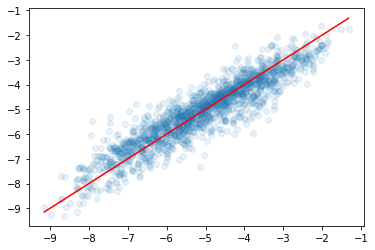

In [23]:
plt.scatter(y_train, y_pred_train, alpha=0.1)
plt.plot([y.min(), y.max()], [y.min(), y.max()], c="red")
plt.show()

In [24]:
y_test_pred = rcv.predict(X_test)
np.mean((y_test_pred - y_test)**2)

0.31897659071338985

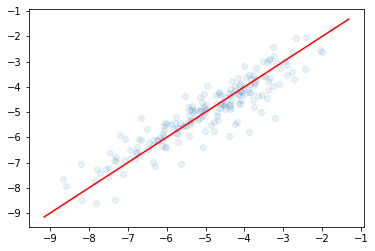

In [25]:
plt.scatter(y_test, y_test_pred, alpha=0.1)
plt.plot([y.min(), y.max()], [y.min(), y.max()], c="red")
plt.show()

In [26]:
seed_everything()
all_ys = []
all_y_hats = []
all_ys_train = []
all_y_hats_train = []

for train_indices, test_indices in KFold(n_splits=5, shuffle=True).split(df):
    
    cv_train_df = df.iloc[train_indices]
    cv_test_df = df.iloc[test_indices]
    
    
    cv_X_train = np.vstack(cv_train_df.apply(lambda mol: make_simple_descriptor(mol, elements, one_hot=one_hot), axis=1))
    cv_X_test = np.vstack(cv_test_df.apply(lambda mol: make_simple_descriptor(mol, elements, one_hot=one_hot), axis=1))
    cv_y_train = y.iloc[train_indices] # cv_train_df.enthalpy_atom
    cv_y_test = y.iloc[test_indices] # cv_test_df.enthalpy_atom
    
    rcv = RidgeCV()
    rcv.fit(cv_X_train, cv_y_train)
    y_hats = rcv.predict(cv_X_test)
    
    y_hats_train = rcv.predict(cv_X_train)
    print("Train:", np.mean((y_hats_train - cv_y_train)**2),
          "Test:", np.mean((y_hats - cv_y_test)**2))
    
    all_ys.append(cv_y_test)
    all_y_hats.append(y_hats)
    
    all_ys_train.append(cv_y_train)
    all_y_hats_train.append(y_hats_train)

    
print("Avg Train: ", np.mean((np.hstack(all_ys_train) - np.hstack(all_y_hats_train))**2), end=" ")
print("Avg Test: ", np.mean((np.hstack(all_ys) - np.hstack(all_y_hats))**2))

Train: 0.3178202609514905 Test: 0.3126395930968473
Train: 0.31246855271896573 Test: 0.3335391828186628
Train: 0.30158992051620803 Test: 0.3775706099624331
Train: 0.31157019351234155 Test: 0.33134994413329283
Train: 0.30811938438263886 Test: 0.3548655962890664
Avg Train:  0.31031337430209127 Avg Test:  0.3419862244349402


## MLP

In [27]:
one_hot = False

In [28]:
X_train = np.vstack(train_df.apply(lambda mol: make_simple_descriptor(mol, elements, one_hot=one_hot), axis=1))
X_test = np.vstack(test_df.apply(lambda mol: make_simple_descriptor(mol, elements, one_hot=one_hot), axis=1))

In [29]:
from sklearn.neural_network import MLPRegressor

In [30]:
mlp = MLPRegressor(random_state=0, max_iter=5000)
mlp.fit(X_train, y_train)

MLPRegressor(max_iter=5000, random_state=0)

In [31]:
y_pred_train = mlp.predict(X_train)
np.mean((y_pred_train - y_train)**2)

0.017788457091297966

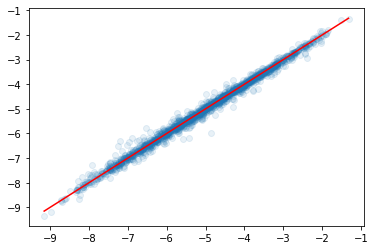

In [32]:
plt.scatter(y_train, y_pred_train, alpha=0.1)
plt.plot([y.min(), y.max()], [y.min(), y.max()], c="red")
plt.show()

In [33]:
y_test_pred = mlp.predict(X_test)
np.mean((y_test_pred - y_test)**2)

0.22099334586178102

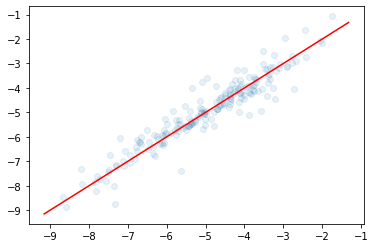

In [34]:
plt.scatter(y_test, y_test_pred, alpha=0.1)
plt.plot([y.min(), y.max()], [y.min(), y.max()], c="red")
plt.show()

In [35]:
seed_everything()
all_ys = []
all_y_hats = []
all_ys_train = []
all_y_hats_train = []

for train_indices, test_indices in KFold(n_splits=5, shuffle=True).split(df):
    
    cv_train_df = df.iloc[train_indices]
    cv_test_df = df.iloc[test_indices]
    
    
    cv_X_train = np.vstack(cv_train_df.apply(lambda mol: make_simple_descriptor(mol, elements, one_hot=one_hot), axis=1))
    cv_X_test = np.vstack(cv_test_df.apply(lambda mol: make_simple_descriptor(mol, elements, one_hot=one_hot), axis=1))
    cv_y_train = y.iloc[train_indices] # cv_train_df.enthalpy_atom
    cv_y_test = y.iloc[test_indices] # cv_test_df.enthalpy_atom
    
    mlp = MLPRegressor(random_state=0, max_iter=5000)
    mlp.fit(cv_X_train, cv_y_train)
    y_hats = mlp.predict(cv_X_test)
    
    y_hats_train = mlp.predict(cv_X_train)
    print("Train:", np.mean((y_hats_train - cv_y_train)**2),
          "Test:", np.mean((y_hats - cv_y_test)**2))
    
    all_ys.append(cv_y_test)
    all_y_hats.append(y_hats)
    
    all_ys_train.append(cv_y_train)
    all_y_hats_train.append(y_hats_train)
    

print("Avg Train: ", np.mean((np.hstack(all_ys_train) - np.hstack(all_y_hats_train))**2), end=" ")
print("Avg Test: ", np.mean((np.hstack(all_ys) - np.hstack(all_y_hats))**2))

Train: 0.013989953432060043 Test: 0.24456395859603813
Train: 0.012476417080240821 Test: 0.27310441877099795
Train: 0.022838660768905648 Test: 0.2951134674904405
Train: 0.015546774319572774 Test: 0.3186995329232572
Train: 0.014051106011699862 Test: 0.3270071418993867
Avg Train:  0.0157803552378962 Avg Test:  0.2916791590631442
